# MRI Brain Tumour Classifier, based on Google's Mobilenetv3 Model
References:
- https://blog.research.google/2019/11/introducing-next-generation-on-device.html
- https://www.kaggle.com/models/google/mobilenet-v3/frameworks/tensorFlow2
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.tensorflow.org/tutorials/load_data/images

In [1]:
# Import required functions and libraries
from utils import *

# Dataset Preparations

Found 480 files belonging to 4 classes.
Using 384 files for training.
Using 96 files for validation.

Training Dataset Preview


2024-06-11 23:32:16.231467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


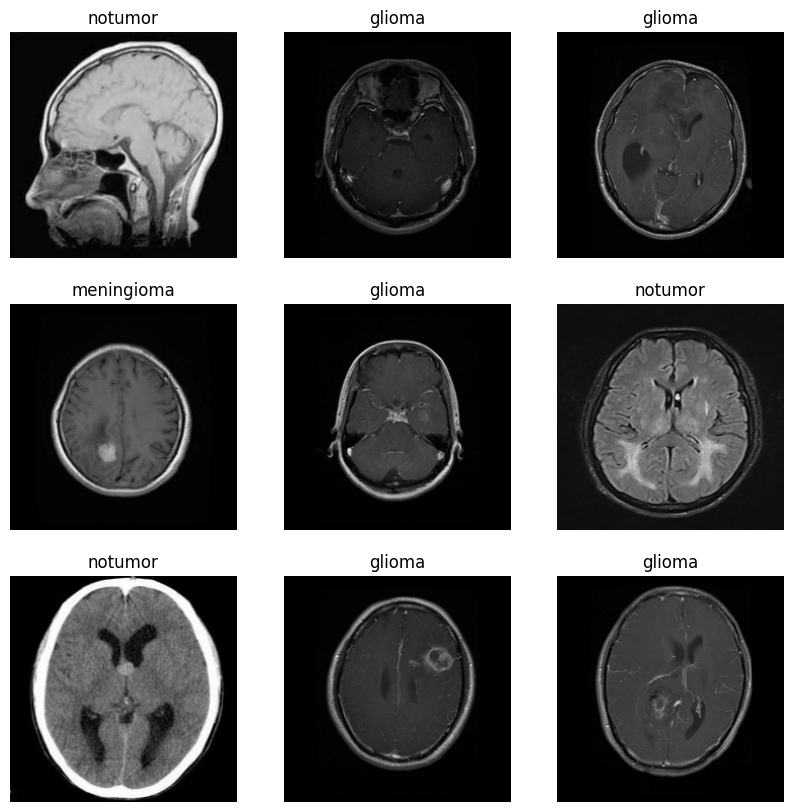

Validation Dataset Preview


2024-06-11 23:32:16.588835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


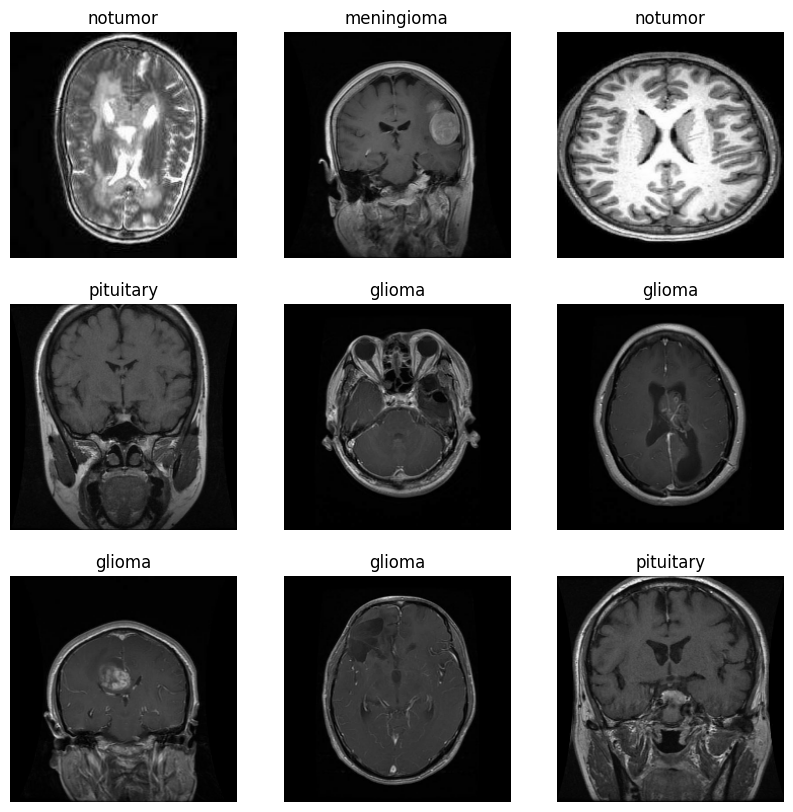

In [2]:
# Parameters
img_batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width) # MobilenetV3 requires 224x224 input images
img_shape = img_size + (3,)

# Get training and validation datasets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="both",
  shuffle=True,
  seed=RANDOM_STATE,
  image_size=img_size,
  batch_size=img_batch_size)

# Get class names
class_names = train_ds.class_names
# class_names = val_ds.class_names

# Enable buffered prefetching to overlap data preprocessing and model execution during training, to speed up access to dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Preview datasets
print("\nTraining Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

print("Validation Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()    

## Build the base model
Create a base model, by attaching a new classification head on top of the MovileNetV3 model for transfer learning.

In [3]:
# Input layer
inputs = keras.Input(shape=img_shape)

# Preprocessing layers (data augmetation)
x = tf.keras.layers.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)

# Base model layer, ensure that the model is running in inference mode
base_model = tf.keras.applications.MobileNetV3Small(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model(x, training=False) 

# Processing layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.3)(x)

# tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
# tf.keras.layers.Dense(256, kernel_regularizer= tf.keras.regularizers.l2( 0.016), activity_regularizer= tf.keras.regularizers.l1(0.006),
#             bias_regularizer= tf.keras.regularizers.l1(0.006), activation= 'relu'),
# tf.keras.layers.Dropout(rate= 0.45, seed= 123),

# from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
# x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.3)(x)
# x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.4)(x)
# x = Flatten()(x)
# x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# Output layer (use softmax for multi-label classification task)
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)

# Create model
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

base_model.summary()
model.summary()

Model: "MobilenetV3small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 576)            │         2,304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,536,372 (5.86 MB)

 Trainable params: 596,100 (2.27 MB)

 Non-trainable params: 940,272 (3.59 MB)

## Model Training

In [4]:
history = model.fit(train_ds, validation_data=val_ds, epochs=100, batch_size=32, verbose=0)

# Early stopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping], verbose=0)

## Visualise Training

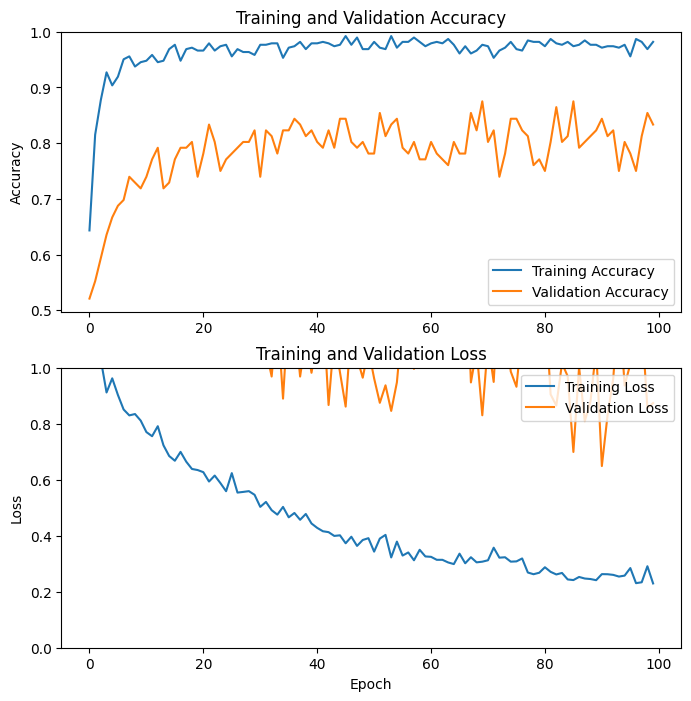

Training Results:
~Accuracy~
Max (best) accuracy: 0.9921875 at epoch 46
Min (worst) accuracy: 0.6432291865348816 at epoch 1
Median accuracy: 0.9739583134651184
Mean accuracy: 0.9646614569425583

~Loss~
Min (best) loss: 0.2295932173728943 at epoch 100
Max (worst) loss: 1.674128532409668 at epoch 1
Median loss: 0.3818705826997757
Mean loss: 0.46495465949177744

~Final Training Performance~
Accuracy: 0.9895833134651184, Loss: 0.2299424409866333

Validation Results:
~Accuracy~
Max (best) accuracy: 0.875 at epoch 70
Min (worst) accuracy: 0.5208333134651184 at epoch 1
Median accuracy: 0.8020833134651184
Mean accuracy: 0.7858333325386048

~Loss~
Min (best) loss: 0.6488372683525085 at epoch 91
Max (worst) loss: 1.9844053983688354 at epoch 2
Median loss: 1.1224355697631836
Mean loss: 1.1283758413791656

~Final Validation Performance~
Accuracy: 0.8333333134651184, Loss: 0.8738479614257812


In [5]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(val_ds, verbose=0)))

## Model Performance

In [6]:
print("~Training Metrics~")
get_model_metrics(train_ds, model)

print("\n~Validation Metrics~")
get_model_metrics(val_ds, model)

~Training Metrics~


2024-06-11 23:34:59.516677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy: 0.9895833333333334
Precision: 0.9900990099009901
Recall: 0.989247311827957
F1 Score: 0.9894549894549894
Matthews Correlation Coefficient (MCC): 0.9862503579240811
Cohen's Kappa: 0.986107593791831
Hamming Loss: 0.010416666666666666

Confusion Matrix:
 [[97  0  0  0]
 [ 4 89  0  0]
 [ 0  0 97  0]
 [ 0  0  0 97]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        97
           1       1.00      0.96      0.98        93
           2       1.00      1.00      1.00        97
           3       1.00      1.00      1.00        97

    accuracy                           0.99       384
   macro avg       0.99      0.99      0.99       384
weighted avg       0.99      0.99      0.99       384



~Validation Metrics~
Accuracy: 0.8333333333333334
Precision: 0.8341018143649723
Recall: 0.8438003220611916
F1 Score: 0.8311687968434367
Matthews Correlation Coefficient (MCC): 0.7835065504917808
Cohen's Kappa: 0.7784

2024-06-11 23:34:59.876784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# K-Fold Cross-Validation to validate model performance

In [ ]:
""" K-Fold Cross-Validation """
from sklearn.model_selection import StratifiedKFold, KFold

# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=img_size,
    batch_size=img_batch_size
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=100, batch_size=32, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {1}, Loss: {0}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {1}, Loss: {0}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

print("Stratified K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in skf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=100, batch_size=32, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_skf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {1}, Loss: {0}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {1}, Loss: {0}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

In [8]:
# Export model
model.save(MODEL_FILE)

# Load the trained model
# model = keras.models.load_model(MODEL_FILE)